<a href="https://colab.research.google.com/github/dinusha94/Machine-learning/blob/master/Super_Resalution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!tar -xzvf gdrive/My\ Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [0]:
!pip install tensorflow-gpu==1.15 
!pip install keras

In [4]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [0]:
!gsutil cp -r /content/gdrive/My\ Drive/train.npz /content/

In [0]:
import sys
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# python magic function, displays pyplot figures in the notebook
%matplotlib inline

In [0]:
def psnr(target, ref):
  # assume RGB image
  target_data = target.astype(float)
  ref_data = ref.astype(float)

  diff = ref_data - target_data
  diff = diff.flatten('C')

  rmse = math.sqrt(np.mean(diff ** 2.))

  return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
  # the MSE between the two images is the sum of the squared difference between the two images
  err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
  err /= float(target.shape[0] * target.shape[1])
    
  return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
  scores = []
  scores.append(psnr(target, ref))
  scores.append(mse(target, ref))
  scores.append(ssim(target, ref, multichannel =True))
    
  return scores

In [0]:
def prepare_images(path, factor):
  for file in os.listdir(path): 
      img = cv2.imread(path + '/' + file)

      h, w, _ = img.shape
      new_height = round(h / factor)
      new_width = round(w / factor)

      # resize the image - down
      img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
      # resize the image - up
      img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

      cv2.imwrite('images/'+file, img)

prepare_images('./source', 2)

In [0]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
  # open target and reference images
  target = cv2.imread('images/{}'.format(file))
  ref = cv2.imread('source/{}'.format(file))
    
  # calculate score
  scores = compare_images(target, ref)

  # print all three scores with new line characters (\n) 
  print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

In [0]:
# define the SRCNN model
def model():
  SRCNN = Sequential()
    
  # add model layers
  SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
  SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
  SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
  # define optimizer
  adam = Adam(lr=0.0003)
    
  # compile model
  SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
  return SRCNN

In [0]:

def modcrop(img, scale):
  tmpsz = img.shape
  sz = tmpsz[0:2]
  sz = sz - np.mod(sz, scale)
  img = img[0:sz[0], 1:sz[1]]
  return img


def shave(image, border):
  img = image[border: -border, border: -border]
  return img


def predict(image_path):
  # load the srcnn model with weights
  srcnn = model()
  srcnn.load_weights('./source/3051crop_weight_200.h5')
    
  # load the degraded and reference images
  path, file = os.path.split(image_path)
  degraded = cv2.imread(image_path)
  ref = cv2.imread('source/{}'.format(file))
    
  # preprocess the image with modcrop
  ref = modcrop(ref, 3)
  degraded = modcrop(degraded, 3)
    
  # convert the image to YCrCb - (srcnn trained on Y channel)
  temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
  # create image slice and normalize  
  Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
  Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
  # perform super-resolution with srcnn
  pre = srcnn.predict(Y, batch_size=1)
    
  # post-process output
  pre *= 255
  pre[pre[:] > 255] = 255
  pre[pre[:] < 0] = 0
  pre = pre.astype(np.uint8)
    
  # copy Y channel back to image and convert to BGR
  temp = shave(temp, 6)
  temp[:, :, 0] = pre[0, :, :, 0]
  output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
  # remove border from reference and degraged image
  ref = shave(ref.astype(np.uint8), 6)
  degraded = shave(degraded.astype(np.uint8), 6)
    
  # image quality calculations
  scores = []
  scores.append(compare_images(degraded, ref))
  scores.append(compare_images(output, ref))
    
  # return images and scores
  return ref, degraded, output, scores

In [20]:
ref, degraded, output, scores = predict('./images/flowers.bmp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.660220614739448
MSE: 210.95001184974524
SSIM: 0.8989099578687939



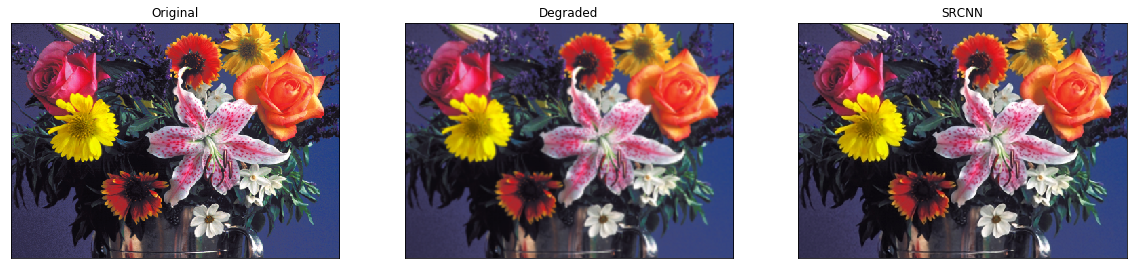

In [21]:
# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
  ax.set_xticks([])
  ax.set_yticks([])

In [0]:
#ref, degraded, output, scores = predict('1.bmp')

srcnn = model()
srcnn.load_weights('./source/3051crop_weight_200.h5')
    
# load the degraded and reference images
degraded = cv2.imread('1.bmp')
#ref = cv2.imread('source/{}'.format(file))
    
# preprocess the image with modcrop
#ref = modcrop(ref, 3)
degraded = modcrop(degraded, 3)
    
# convert the image to YCrCb - (srcnn trained on Y channel)
temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
# create image slice and normalize  
Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
# perform super-resolution with srcnn
pre = srcnn.predict(Y, batch_size=1)
    
# post-process output
pre *= 255
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)
    
# copy Y channel back to image and convert to BGR
temp = shave(temp, 6)
temp[:, :, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
# remove border from reference and degraged image
#ref = shave(ref.astype(np.uint8), 6)
degraded = shave(degraded.astype(np.uint8), 6)

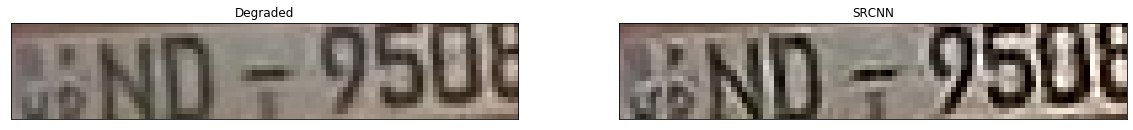

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[0].set_title('Degraded')
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
  ax.set_xticks([])
  ax.set_yticks([])